In [1]:
import pandas as pd
import sklearn as sk
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

In [2]:
#Importing files and Extracting datasets
train = pd.read_table('train.tsv')
# X_t = train['statement']
Y_t = train['label']

test = pd.read_table('test.tsv')
# X_te = test['statement']
Y_te = test['label']


In [3]:
# Predefined Text Cleaning Functions

#Text cleaning
import re, string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# #Clean emojis from text
def strip_emoji(text):
    return emoji.demojize(text) #remove emoji

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text

#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def preprocess(text):
    text = strip_emoji(text)
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [4]:
#  Cleaning X datasets
X_t = []
for t in train.statement:
    X_t.append(preprocess(t))

X_te = []
for t in test.statement:
    X_te.append(preprocess(t))


In [5]:
# # Consolidating Y datasets

Y_train = []
# for t in train.party_affiliation:
#         Y_train.append(t);
for t in train.label:
    if t == 'true' or t == 'mostly-true':
        Y_train.append('true')
    # elif t == 'barely-true' or t == 'half-true': 
    #     Y_train.append('partially-true')
    else:
        Y_train.append('false')

Y_test = []
# for t in test.party_affiliation:
#         Y_test.append(t);
for t in test.label:
    if t == 'true' or t == 'mostly-true':
        Y_test.append('true')
    # elif t == 'barely-true' or t == 'half-true': 
    #     Y_test.append('partially-true')
    else: 
        Y_test.append('false')


In [6]:
# vectorizing and transforming our dataset
vec = TfidfVectorizer()
X_train = vec.fit_transform(X_t)
X_test = vec.transform(X_te)

# tfidf = TfidfTransformer()
# clf = CountVectorizer()

# X_train =  clf.fit_transform(X_t)
# X_test =  clf.transform(X_te)

# tf_transformer = TfidfTransformer(use_idf=True).fit(X_train)
# X_train = tf_transformer.transform(X_train)
# X_test = tf_transformer.transform(X_test)

#Legacy code, we won't need this anymore
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(x_m, Y, random_state=42)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

def cv(data):
    count_vectorizer = CountVectorizer()

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer

# list_corpus = clean_questions["text"].tolist()
# list_labels = clean_questions["class_label"].tolist()

# X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, 
#                                                                                 random_state=40)

X_train_counts, count_vectorizer = cv(X_t)
X_test_counts = count_vectorizer.transform(X_te)



In [8]:
# Turning Y_train into 0s and 1s

Y_train_num = []
for t in Y_train:
    if t == 'true':
        Y_train_num.append(1)
    else:
        Y_train_num.append(0)
        

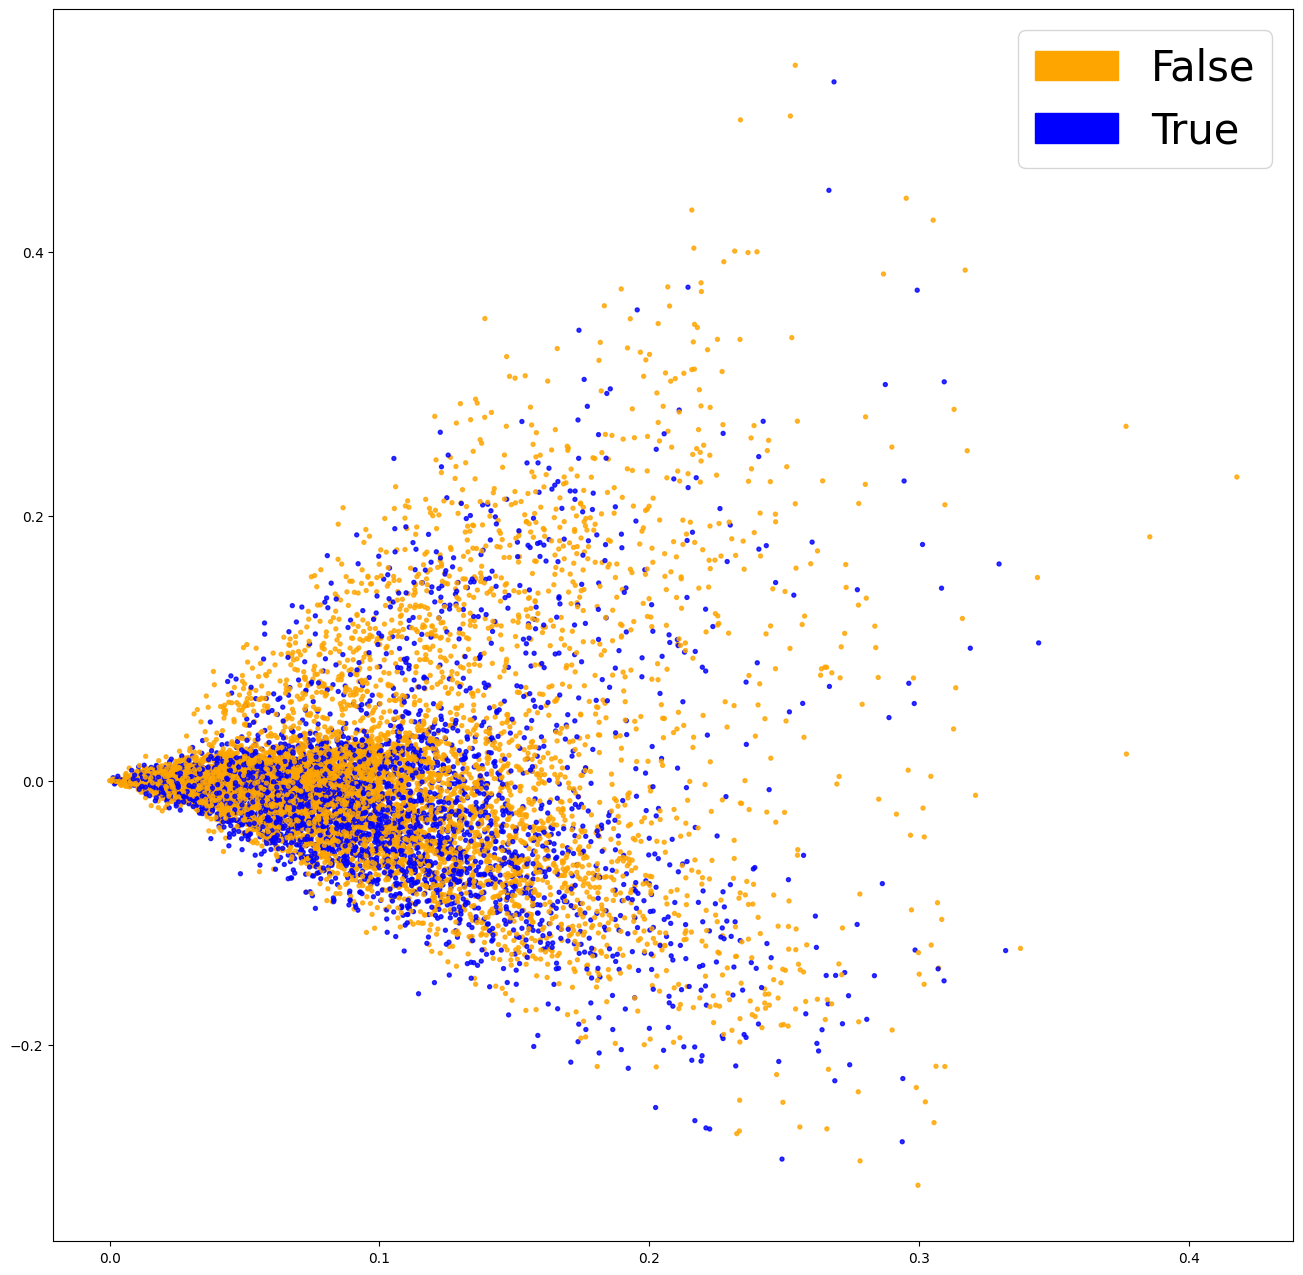

In [9]:
# visualizing vector data for regular vectorization
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt



def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], c=test_labels, s=8, alpha=.8, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='False')
            green_patch = mpatches.Patch(color='blue', label='True')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})

# 
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train, Y_train_num)
plt.show()



In [10]:
#Testing MultinominalNB
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,Y_train)
y_pred = nb.predict(X_test)

from sklearn import metrics
metrics.accuracy_score(Y_test, y_pred)
print(metrics.classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

       false       0.65      0.98      0.78       818
        true       0.56      0.05      0.09       449

    accuracy                           0.65      1267
   macro avg       0.61      0.51      0.44      1267
weighted avg       0.62      0.65      0.54      1267



In [11]:
# Testing RandomForest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, Y_train)
y_pred = rf_clf.predict(X_test)

from sklearn import metrics
metrics.accuracy_score(Y_test, y_pred)
print(metrics.classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

       false       0.67      0.89      0.76       818
        true       0.49      0.19      0.28       449

    accuracy                           0.64      1267
   macro avg       0.58      0.54      0.52      1267
weighted avg       0.60      0.64      0.59      1267



In [12]:
# Testing NearestNeighbor
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, Y_train)
y_pred = knn_clf.predict(X_test)

from sklearn import metrics
metrics.accuracy_score(Y_test, y_pred)
print(metrics.classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

       false       0.66      0.89      0.76       818
        true       0.47      0.19      0.27       449

    accuracy                           0.64      1267
   macro avg       0.57      0.54      0.51      1267
weighted avg       0.60      0.64      0.59      1267



In [13]:
#Testing lightgbm
import lightgbm as lgb
from sklearn import metrics
clf = lgb.LGBMClassifier(random_state=0)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(Y_test, y_pred)
print(metrics.classification_report(Y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

       false     0.6695    0.8594    0.7527       818
        true     0.4700    0.2272    0.3063       449

    accuracy                         0.6354      1267
   macro avg     0.5698    0.5433    0.5295      1267
weighted avg     0.5988    0.6354    0.5945      1267



In [14]:
# IMPORTANT!!
# Replace Vec with a new Embedding Model to compare performances!

X_train = vec.transform(X_t)
X_test = vec.transform(X_te)


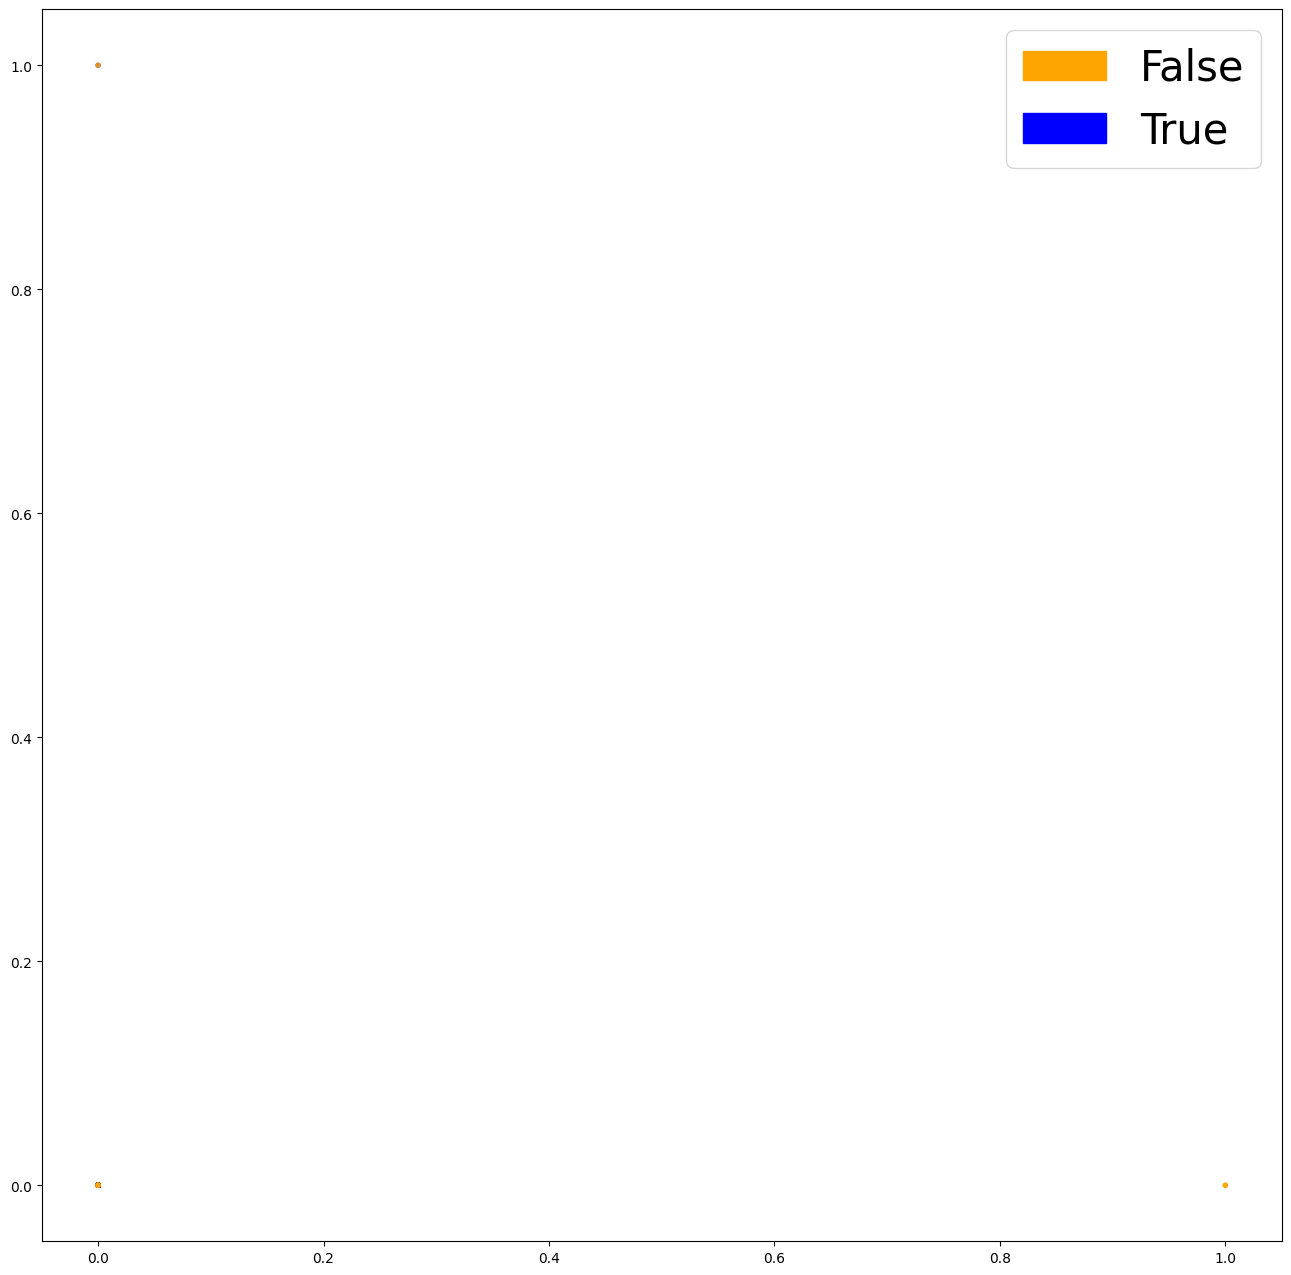

In [15]:
# # Plotting embeddings
fig = plt.figure(figsize=(16, 16))          
plot_LSA(X_train.astype(int), Y_train_num)
plt.show()


In [18]:
#NEW MultinominalNB
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,Y_train)
y_pred = nb.predict(X_test)

from sklearn import metrics
metrics.accuracy_score(Y_test, y_pred)
print(metrics.classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

       false       0.65      0.98      0.78       818
        true       0.56      0.05      0.09       449

    accuracy                           0.65      1267
   macro avg       0.61      0.51      0.44      1267
weighted avg       0.62      0.65      0.54      1267



In [19]:
# NEW RandomForest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, Y_train)
y_pred = rf_clf.predict(X_test)

from sklearn import metrics
metrics.accuracy_score(Y_test, y_pred)
print(metrics.classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

       false       0.67      0.90      0.77       818
        true       0.53      0.20      0.30       449

    accuracy                           0.66      1267
   macro avg       0.60      0.55      0.53      1267
weighted avg       0.62      0.66      0.60      1267



In [20]:
# NEW NearestNeighbor
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train, Y_train)
y_pred = knn_clf.predict(X_test)

from sklearn import metrics
metrics.accuracy_score(Y_test, y_pred)
print(metrics.classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

       false       0.66      0.89      0.76       818
        true       0.47      0.19      0.27       449

    accuracy                           0.64      1267
   macro avg       0.57      0.54      0.51      1267
weighted avg       0.60      0.64      0.59      1267



In [21]:
# NEW lightgbm
import lightgbm as lgb
from sklearn import metrics
clf = lgb.LGBMClassifier(random_state=0)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)
metrics.accuracy_score(Y_test, y_pred)
print(metrics.classification_report(Y_test, y_pred, digits = 4))

              precision    recall  f1-score   support

       false     0.6695    0.8594    0.7527       818
        true     0.4700    0.2272    0.3063       449

    accuracy                         0.6354      1267
   macro avg     0.5698    0.5433    0.5295      1267
weighted avg     0.5988    0.6354    0.5945      1267

